Notebook to genereate scatter plots from TC output

James Ruppert  
jruppert@ou.edu  
June 2022

### Main settings

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from thermo_functions import *
from precip_class import *
from read_functions import *

In [6]:
# Read and write variables, or load in saved pickle?
do_write=True
# do_write=False

storm = 'haiyan'

main = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/"
datdir2 = 'post/d02/'

# Number of sample time steps (if only running CTL)
nt=200 # will be chopped down to max available
# nt=48
# nt=12

t1_test=48 # n time steps to sample for tests

# Members
nmem = 10 # number of ensemble members (1-5 have NCRF)
# nmem = 3
enstag = str(nmem)

In [7]:
# Ensemble member info
memb0=1 # Starting member to read
memb_nums=np.arange(memb0,nmem+memb0,1)
memb_nums_str=memb_nums.astype(str)
nustr = np.char.zfill(memb_nums_str, 2)
memb_all=np.char.add('memb_',nustr)

# Get dimensions
test_str='ctl'
datdir = main+storm+'/'+memb_all[0]+'/'+test_str+'/'+datdir2
# datdir = "/Users/jamesruppert/code/tc_postproc/"
nt_data, nz, nx1, nx2, pres = get_file_dims(datdir)
# nt_data, nz, nx1, nx2 = get_file_dims(datdir)
# dp = (pres[1]-pres[0])*1e2 # Pa
nt=t1_test
nx1-=80*2
nx2-=80*2

In [8]:
# Tests to read and compare
if storm == 'haiyan':
    tests = ['ctl','ncrf36h','STRATANVIL_ON','STRATANVIL_OFF','STRAT_OFF']
    tests_str = ['CTL','NCRF','STRATANVON','STRATANVOFF','STRATOFF']
elif storm == 'maria':
    # tests = ['ctl','ncrf36h']
    tests = ['ctl','ncrf48h']
    tests_str = ['CTL','NCRF']

ntest = len(tests)

### Read loop

In [10]:
# Main read loops for 3D (dependent) variables

if do_write:

    # Arrays to save variables
    dims = (ntest, nmem, nt, nx1, nx2)
    pclass = np.ma.zeros(dims)
    lwp    = np.ma.zeros(dims)
    rain   = np.ma.zeros(dims)
    vmf    = np.ma.zeros(dims)
    condh  = np.ma.zeros(dims)

    for itest in range(ntest):
    # for itest in range(1):

        test_str = tests[itest]
        print()
        print('Running test: ',test_str)

        # t0=time_neglect # neglect the first 12 time steps
        # t1=t0+nt
        if test_str == 'ctl':
            t0=36
            t1=t0+t1_test
        else:
            t0=0
            t1=t1_test

        # Loop over ensemble members
        for imemb in range(nmem):
        # for imemb in range(1):

            print('Running imemb: ',memb_all[imemb])

            datdir = main+storm+'/'+memb_all[imemb]+'/'+test_str+'/'+datdir2

            # Stratiform ID
            q_int = read_qcloud(datdir,t0,t1,mask=True,drop=True) # mm
            ipclass = precip_class(q_int)

            # Rain rate
            varname = 'rainrate'
            irain = var_read_2d(datdir,varname,t0,t1,mask=True,drop=True) # mm/d

            # LWACRE
            lw = read_lwnet(datdir,t0,t1,mask=True,drop=True) # W/m2
            lwm = np.mean(lw, axis=(1,2))
            ilwp = lw - lwm[:,np.newaxis,np.newaxis]

            # Vertical motion
            ivmf = read_mse_diag(datdir, 'vmf', t0, t1, mask=True, drop=True) # kg/m/s

            # Condensation heating
            icondh = read_mse_diag(datdir, 'condh', t0, t1, mask=True, drop=True) # mm/d

            # Save variables for each ens member
            pclass[itest,imemb,:,:,:] = ipclass
            rain[itest,imemb,:,:,:]   = irain
            lwp[itest,imemb,:,:,:]    = ilwp
            vmf[itest,imemb,:,:,:]    = ivmf
            condh[itest,imemb,:,:,:]  = icondh


Running test:  ctl
Running imemb:  memb_01
(48, 580, 1040)
177.42114
-104.969894


IndexError: too many indices for array: array is 3-dimensional, but 5 were indexed

---

#### Statistics from Rogers conv/strat index

In [6]:
ncell=nx1*nx2*nt

indices = (strat1 == 0).nonzero()
count = np.shape(indices[1])[0]
print("N non-raining = ",count)
print("% non-raining = ",count/ncell*100)
print()

indices = (strat1 == 1).nonzero()
count = np.shape(indices[1])[0]
print("N conv = ",count)
print("% conv = ",count/ncell*100)
print()

indices = (strat1 == 2).nonzero()
count = np.shape(indices[1])[0]
print("N strat = ",count)
print("% strat = ",count/ncell*100)
print()

indices = (strat1 == 3).nonzero()
count = np.shape(indices[1])[0]
print("N other = ",count)
print("% other = ",count/ncell*100)
print()

N non-raining =  22029041
% non-raining =  88.59813787001288

N conv =  185322
% conv =  0.745342664092664

N strat =  1688847
% strat =  6.792338320463321

N other =  960790
% other =  3.8641811454311457



#### New conv/strat index

In [7]:
strat2 = stratiform_index(rain,vmf_lower,vmf_upper,verbose=1)

After rainfall threshold:
N non-raining =  15027361
% non-raining =  60.438227960102964

N conv =  5762316
% conv =  23.175337837837837

N strat =  4074323
% strat =  16.386434202059203

After VMF threshold:
N non-raining =  20702847
% non-raining =  83.26434604247103

N conv =  607196
% conv =  2.4420688545688547

N strat =  3553957
% strat =  14.293585102960101

After VMF TOPHEAVINESS threshold:
N non-raining =  20702847
% non-raining =  83.26434604247103

N conv =  607196
% conv =  2.4420688545688547

N strat =  3553957
% strat =  14.293585102960101



#### Axis settings

In [48]:
if ivar_select == 'pw':
    # PW
    binfil = Dataset(datdir+'PW.nc') # this opens the netcdf file
    ivar = binfil.variables['PW'][t0:t1,:,:,:]
    binfil.close()
    fmin=35;fmax=80 # mm
    step=1
    bins=np.arange(fmin,fmax+step,step)
    xlabel='Column water vapor [mm]'
    log_x='linear'
    
elif ivar_select == 'rain':
    # Rainfall rate
    ivar = rain # mm/hr
    fmin=0; fmax=140 # mm / hr
    bins=10.**(np.arange(1,8,0.3)-4)
    xlabel='Rainfall rate [mm/hr]'
    log_x='log'

elif ivar_select == 'vmf':
    # Vertical mass flux
    dp=10000. # delta-p, Pa
    g=9.81 # gravity, m/s2
    wv_int = np.sum(w,1) * dp/g # m/s * s**2/m * kg/m/s**2 = kg/s/m
    ivar = np.reshape(wv_int,(nt,1,nx1,nx2))
    fmin=0; fmax=140 # mm / hr
    bins=10.**(np.arange(1,8,0.3)-3)
    # bins=np.flip(-1.*bins)
    xlabel='Vertical mass flux [kg/m/s]'
    log_x='log'

elif ivar_select == 'lwacre':
    # LW-ACRE
    ivar = lwacre
    fmin=-50; fmax=200 # W/m2
    step=5
    bins=np.arange(fmin,fmax+step,step)
    xlabel='LW-ACRE [W/m**2]'
    log_x='linear'


print("Binvar shape: ",np.shape(ivar))
print(bins)
nbins = np.size(bins)
print(nbins)

Binvar shape:  (24, 1, 740, 1400)
[1.00000000e-02 1.99526231e-02 3.98107171e-02 7.94328235e-02
 1.58489319e-01 3.16227766e-01 6.30957344e-01 1.25892541e+00
 2.51188643e+00 5.01187234e+00 1.00000000e+01 1.99526231e+01
 3.98107171e+01 7.94328235e+01 1.58489319e+02 3.16227766e+02
 6.30957344e+02 1.25892541e+03 2.51188643e+03 5.01187234e+03
 1.00000000e+04 1.99526231e+04 3.98107171e+04 7.94328235e+04]
24


#### Bin the target variable

---
### Plotting routines

In [31]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

### Conv/Strat Area

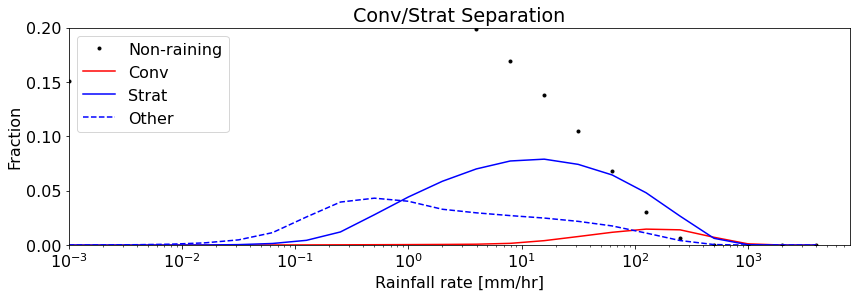

In [40]:
# create figure
fig = plt.figure(figsize=(14,4))
ax = fig.add_subplot(111)

ax.set_title('Conv/Strat Separation')
ax.set_xlabel(xlabel)
ax.set_xscale(log_x)

# Conv/strat separation: varout = 1 if convective, = 2 if stratiform, = 3 other, = 0 if no rain

# As fraction of all-rain-total
ax.set_ylabel('Fraction')
total=np.sum(binvar_s_mn[:,(1,2,3)])
plt.plot(bins[0:nbins-1], binvar_s_mn[:,0]/total \
         , ".k", label="Non-raining")
plt.plot(bins[0:nbins-1], binvar_s_mn[:,1]/total \
         , "-r", label="Conv")
plt.plot(bins[0:nbins-1], binvar_s_mn[:,2]/total \
         , "-b", label="Strat")
plt.plot(bins[0:nbins-1], binvar_s_mn[:,3]/total \
         , "--b", label="Other")

plt.xlim(np.min(bins), np.max(bins))
plt.ylim(0, 0.2)

plt.legend(loc="upper left")

plt.show()
# plt.savefig(figdir+'convstrat_comp_'+imemb+'_'+ivar_select+'.png',dpi=200, facecolor='white', \
#             bbox_inches='tight', pad_inches=0.2)